데이터 저장

In [30]:
import os
from datetime import datetime
import pandas as pd

# Create a directory to store the results
dir = 'LO_results_dir'
if not os.path.exists(dir):
    os.makedirs(dir)

# CSV file name setup
date = datetime.now()
printdate = date.strftime('%Y%m%d_%H%M%S')
# filename = "/ByLO_dt_" + str(dt) + "_" + printdate + '.csv'
filename = "/ByLO_dt_" + "change_" + printdate + '.csv'

# Create an empty DataFrame and write to CSV file
saved_df = pd.DataFrame(columns=["Case", 'gate length', 'Theta', 'Phi', 'dt', 'combination', 'fidelity',
                           'total time', 'computing time'])
saved_df.to_csv(dir + filename, index=False)

데이터 불러오기

In [31]:
import pandas as pd

df = pd.read_csv('../Data/using/dt_2.6/ByAstar_dt_2.6_1016.csv')
df = df[df['combination'] != '[]']
df = df.drop('Case', axis=1)
df_shuffled = df.sample(frac=1).reset_index(drop=True)

# 결측치나 data type 예외 처리 하지 않았으므로 데이터 사용에 주의 필요

thetas = df_shuffled['Theta'][:100]
phis = df_shuffled['Phi'][:100]
# dts = df_shuffled['dt'][:100]              # dt=2.6이 아닌 다른 값을 사용하는 경우
lists = df_shuffled['combination'][:100]

df_shuffled.head()

,gate length,Theta,Phi,dt,combination,total time,computing time
0,24,2.357367,0.887019,2.6,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",62.4,202.614259
1,33,2.803949,1.352881,2.6,"[1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, ...",85.8,657.520287
2,9,0.641849,2.301648,2.6,"[3, 3, 2, 2, 4, 1, 3, 3, 2]",23.4,28.364168
3,18,1.703635,3.845261,2.6,"[2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, ...",46.8,7.577972
4,13,1.255980,4.194022,2.6,"[3, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2]",33.8,437.687826


Base System

In [32]:
import numpy as np
from math import *
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
# dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


values = np.arange(1.00, 6.01, 0.01)
# 반올림하여 2자리 소수점까지만 표시
dt_values = [round(val, 2) for val in values]

unitary_choiceList = {}

for dt in dt_values:
    unitary_choiceList[dt] = [unitary(dt, i) for i in range(5)]


#########################################################################


# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),  -1j*sin(theta/2)],
                        [-1j*sin(theta/2),  cos(theta/2)]])

# z-rotation operater
# Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
        print("Dimensions of two states do not match.")
        return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        rho_fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(rho_fidelity)


#########################################################################


def fidelity(rho, dt, predicted_seq):

    u = s0
    
    for i in predicted_seq:
        u = unitary_choiceList[dt][i] @ u

    irho_final = u @ irho_init @ u.conj().T
    
    F = (state_fidelity(irho_final, rho))
    
    return  F


#########################################################################


init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


Find the best delta t function

In [33]:
def find_best_dt(seq):
     
    global input_rho
     
    my_dt = 0       # return value
    fid = 0         # final fidelity
    i_fid = 0       # temp fidelity
    
    for i in dt_values:
        
        i_fid = fidelity(input_rho, i, seq)
    
        if fid < i_fid:
            my_dt = i
            fid = i_fid
    
    return my_dt

Find the best sequence function

In [34]:
from itertools import product

def find_best_seq(seq, input_dt):
     
     global input_rho
     
     # when there is no over 0.9999 fidelity of seq, return original sequence
     final_seq = seq      # return value
     temp_seq = []
     # temp_fid = 0
     
     # for i in range(-1, -(len(seq)+1), -1):
     for i in range(-1, -6, -1):
          
          if i < -len(seq):             # if over length
               break
          
          front_seq = seq[:i]
          back_seq = seq[i:]
          
          for combination in product(range(5), repeat=len(back_seq)):
               temp_seq = front_seq + list(combination)
               
               fid = round(fidelity(input_rho, input_dt, temp_seq), 5)
               
               if fid > 0.9999:
                    final_seq = temp_seq
                    return final_seq
               
               # don't need these lines when we just want over 0.9999
               # if fid > temp_fid:
               #      final_seq = temp_seq
               #      temp_fid = fid

               # check the progress
               # print("=============================")
               # print(seq)
               # print(temp_seq)
               # print(final_seq)
               # print("=============================")
     
     return final_seq

Local Optimizer

In [35]:
import time

def local_optimizer(input_rho, input_seq, check_order, input_dt):
     
     first_fid = round(fidelity(input_rho, input_dt, input_seq), 5)        # default dt=2.6

     if first_fid >= 0.9999:
          
          output_dt = input_dt
          output_seq = input_seq
          last_fid = first_fid
          print("        ** input data is already over 0.9999 **", end='\n')

          return output_dt, output_seq, first_fid, last_fid

     if check_order == False:
          print("        ## before seq check, under 0.9999, under theta pi/2 -> need dt check ##", end='\n')
          output_dt = find_best_dt(input_seq)
     else:
          output_dt = input_dt
     
     output_seq = find_best_seq(input_seq, output_dt)
     
     mid_fid = round(fidelity(input_rho, output_dt, output_seq), 5)
     
     if mid_fid < 0.9999:
          print("        ## after seq check, under 0.9999 -> need dt check ##", end='\n')
          output_dt = find_best_dt(output_seq)
     
     last_fid = round(fidelity(input_rho, output_dt, output_seq), 5)
     
     return output_dt, output_seq, first_fid, last_fid

Main Part

In [36]:
case = 0

for input_theta, input_phi, input_sequence in zip(thetas, phis, lists):  
     # for input_theta, input_phi, input_dt, input_sequence in zip(thetas, phis, dts, lists):  
     
     # making rho
     target_U = Rz(input_phi) @ Rx(input_theta)
     input_rho = target_U @ irho_init @ target_U.conj().T
     
     # object to list
     input_sequence = eval(input_sequence)     
     
     # order == True ... theta > 90 : seq -> dt
     # order == False .. theta <= 90 : dt -> seq (-> dt)
     if input_theta > np.deg2rad(90):        # order True
          order = True
     else:                                   # order False
          order = False
     
     # if there is not defined dt value
     temp_dt = 2.6                           # input_dt
     temp_sequence = input_sequence
     last_fidelity = 0     
     
     start_time = time.time()
     
     while last_fidelity < 0.9999:
          
          # get values
          output_dt, output_sequence, first_fidelity, last_fidelity = local_optimizer(input_rho, temp_sequence, order, temp_dt)
     
          if last_fidelity >= 0.9999 or len(output_sequence) > 60 or output_dt < 1.0:
               break
          
          temp_sequence = output_sequence + [0]
          temp_dt = round(output_dt * len(output_sequence) / (len(output_sequence) + 1), 2)
     
     end_time = time.time()
     
     total_time = output_dt * len(output_sequence)
     computing_time = end_time - start_time
     
     # save values
     case += 1
     output = [['case' + str(case), len(output_sequence), input_theta, input_phi, 
                    output_dt, output_sequence, last_fidelity, total_time, computing_time]]
    
     # Create DataFrame and append to CSV file
     saved_df = pd.DataFrame(output, columns=["Case", 'gate length', 'Theta', 'Phi', 
                                                  'dt', 'combination', 'fidelity', 'total time', 'computing time'])
     saved_df.to_csv(dir + filename, mode='a', header=False, index=False)

     # Result output
     print(f"""
     -----------------------------------------------------------------------------------------------------------------------
     theta = {input_theta}
     phi = {input_phi}
     input_dt = 2.6
     output_dt : {output_dt}
     input_sequence : {input_sequence}
     first_fidelity : {first_fidelity}
     output_sequence : {output_sequence}
     last_fidelity : {last_fidelity}
     total_time : {total_time}
     computing_time : {computing_time}
     -----------------------------------------------------------------------------------------------------------------------
     """)
     
     # check progress
     print("        %%%%%%%%%%%%%%%%%%%%%%%%%")
     print("        ", case, "/", len(df_shuffled))
     print("        %%%%%%%%%%%%%%%%%%%%%%%%%")
     print("\n\n")

        ## after seq check, under 0.9999 -> need dt check ##
        ## after seq check, under 0.9999 -> need dt check ##
        ## after seq check, under 0.9999 -> need dt check ##
        ## after seq check, under 0.9999 -> need dt check ##
        ## after seq check, under 0.9999 -> need dt check ##
        ## after seq check, under 0.9999 -> need dt check ##

     -----------------------------------------------------------------------------------------------------------------------
     theta = 2.357367114
     phi = 0.887019211
     input_dt = 2.6
     output_dt : 2.78
     input_sequence : [3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1]
     first_fidelity : 0.9683
     output_sequence : [3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 0, 2, 2, 4, 4, 4]
     last_fidelity : 0.99991
     total_time : 83.39999999999999
     computing_time : 69.90360903739929
     ----------------------------------------------------------------------

결과 데이터 확인

In [43]:
import pandas as pd

result_df = pd.read_csv('../Local_Optimizer/LO_results_dir/ByLO_dt_change_20231207_104151.csv')

result_df.head()

,Case,gate length,Theta,Phi,dt,combination,fidelity,total time,computing time
0,case1,30,2.357367,0.887019,2.78,"[3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, ...",0.99991,83.40,69.903609
1,case2,33,2.803949,1.352881,2.60,"[1, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, ...",0.99995,85.80,0.105284
2,case3,9,0.641849,2.301648,2.66,"[3, 3, 2, 2, 4, 1, 3, 3, 2]",1.00000,23.94,1.628189
3,case4,23,1.703635,3.845261,3.07,"[2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 4, 4, 1, 1, 3, ...",0.99996,70.61,57.860387
4,case5,18,1.255980,4.194022,3.29,"[3, 3, 3, 2, 2, 4, 4, 1, 1, 3, 3, 2, 2, 0, 3, ...",0.99996,59.22,71.817240


In [44]:
result_df['fidelity'].mean()

0.9999509000000001

In [45]:
df2 = result_df[result_df['fidelity'] >= 0.9999]

print(df2['fidelity'].mean())
df2.info()

0.9999509000000001
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Case            100 non-null    object 
 1   gate length     100 non-null    int64  
 2   Theta           100 non-null    float64
 3   Phi             100 non-null    float64
 4   dt              100 non-null    float64
 5   combination     100 non-null    object 
 6   fidelity        100 non-null    float64
 7   total time      100 non-null    float64
 8   computing time  100 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 7.2+ KB


In [46]:
df3 = result_df[result_df['fidelity'] < 0.9999]

print(df3['fidelity'].mean())
df3.info()

nan
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Case            0 non-null      object 
 1   gate length     0 non-null      int64  
 2   Theta           0 non-null      float64
 3   Phi             0 non-null      float64
 4   dt              0 non-null      float64
 5   combination     0 non-null      object 
 6   fidelity        0 non-null      float64
 7   total time      0 non-null      float64
 8   computing time  0 non-null      float64
dtypes: float64(6), int64(1), object(2)
memory usage: 0.0+ bytes


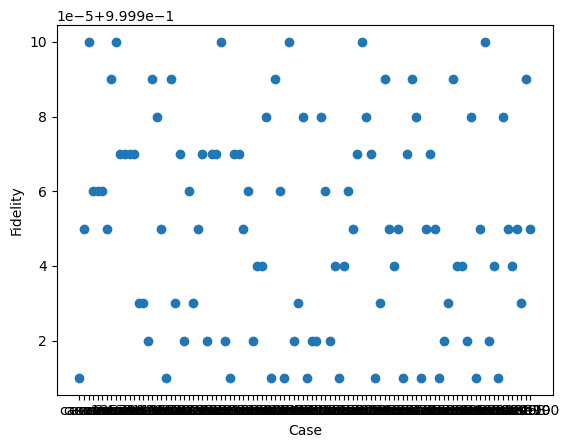

In [47]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(result_df['Case'], result_df['fidelity'], alpha=1)
plt.xlabel('Case')
plt.ylabel('Fidelity')
plt.show()

In [48]:
min(result_df['fidelity'])

0.99991